# Music Generation

In [this project](https://github.com/RasmusML/musicHMM), we will generate music notes using hidden markov models. The models are trained on chorales composed by Bach.

We will explore 4 hidden markov models. The first model is a standard HMM and implemented from scratch. This model assumes a single note is played at each timestep. 
The remaning 3 models are implemented in the probabilistic programming library pyro and support a variable number of notes played at the same timestep. Using pyro, we don't need to implement the (modified) Baum-Welch algorithm for each model variant in order to estimate the models' parameters. By defining an approximate posterior distribution (called a "guide" in pyro), a model's parameters can be estimated.
Instead of using Pyro, we could had implemented the models in pyTorch, since the backpropogation algorithm can be used to estimate the parameters - but I opted for pyro.

Overview of the models:
- HMM-0: single-note, fixed-length
- HMM-1: multiple notes, fixed-length

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam, ClippedAdam

from utils import *
from hmm import HMM

np.random.seed(0)
pyro.set_rng_seed(42)

## Data exploration

The dataset we use is "JSB chorales" and is a set of short, four-voice pieces of music well-noted for their stylistic homogeneity. The chorales were originally composed by Johann Sebastian Bach in the 18th century. He wrote them by first taking pre-existing melodies from contemporary Lutheran hymns and then harmonising them to create the parts for the remaining three voices. The version of the dataset used canonically in representation learning contexts consists of 382 such chorales. The timing of each note in the dataset is the same (here always one quarter note) and these pieces are stored in MIDI format.

Let's load the data.

In [3]:
data = load_jsb_chorales()

In [4]:
print(f"Number of chorales: {len(data)}")

Number of chorales: 382


Let's shuffle the data.

In [5]:
idxs = np.arange(len(data))
np.random.shuffle(idxs)
data = [data[i] for i in idxs]

Let's look at the range of the notes.

In [6]:
notes = [note for chorale in data for t_note in chorale for note in t_note]
lowest_note = np.min(notes)
highest_note = np.max(notes)

print(f"Lowest note:  {str_number_to_note(lowest_note)} ({lowest_note})")
print(f"Highest note: {str_number_to_note(highest_note)} ({highest_note})")

Lowest note:  B1 (23)
Highest note: E6 (76)


The notes are indexed from 1 to 88, where 1 is the lowest note on the piano and 88 is the highest note. The note 0 is interpreted as no note being played. 

Let's look at the distributions of the data.

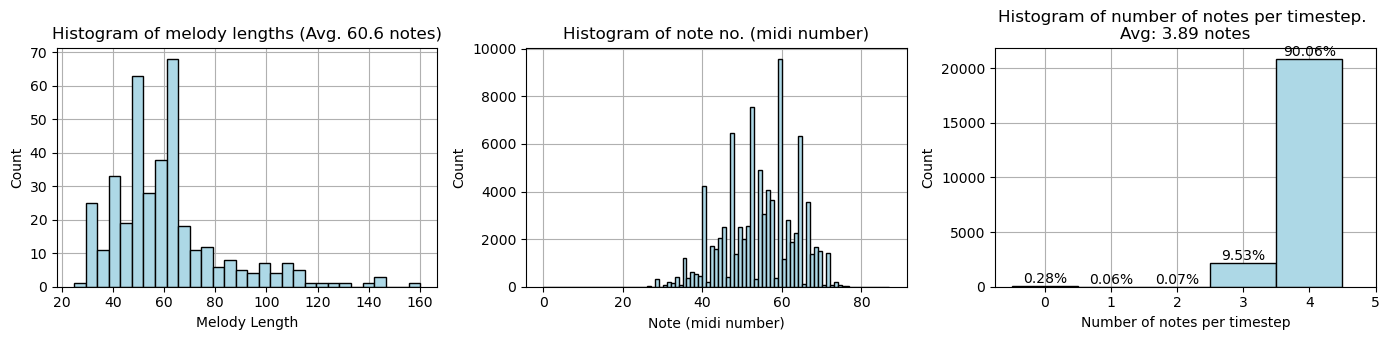

In [7]:
fig, axes = plt.subplots(figsize=(14, 3.5), ncols=3)

ax = axes[0]
lengths = [len(song) for song in data]
ax.hist(lengths, bins=30, color="lightblue", edgecolor="black")
ax.set_xlabel("Melody Length")
ax.set_ylabel("Count")
ax.set_title(f"Histogram of melody lengths (Avg. {np.mean(lengths):.1f} notes)")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
notes = [note for chorale in data for t_note in chorale for note in t_note]
ax.hist(notes, bins=range(0, 88), color="lightblue", edgecolor="black")
ax.set_xlabel("Note (midi number)")
ax.set_ylabel("Count")
ax.set_title("Histogram of note no. (midi number)")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
n_bins = np.max([len(t_notes) for chorale in data for t_notes in chorale])
bins = np.arange(n_bins+2)
notes_per_timestep = [len(t_notes) for chorale in data for t_notes in chorale]
ax.hist(notes_per_timestep, bins=bins, color="lightblue", edgecolor="black", align="left")
ax.set_xlabel("Number of notes per timestep")
ax.set_ylabel("Count")
ax.set_title(f"Histogram of number of notes per timestep. \nAvg: {np.mean(notes_per_timestep):.2f} notes")
ax.set_xticks(bins)
ax.grid(True)
ax.set_axisbelow(True)

for i, count in enumerate(np.bincount(notes_per_timestep)):
    ax.text(i, count, f"{count/len(notes_per_timestep)*100:.2f}%", ha="center", va="bottom")

fig.tight_layout()

Let's look at the most common notes in the dataset.

In [8]:
K = 5

note_perc = np.bincount(notes)
note_perc = note_perc / np.sum(note_perc)
top_k = np.argsort(note_perc)[::-1][:K]

for note in top_k:
    print(f"{str_number_to_note(note)}: {note_perc[note]*100:.1f}%")

B4: 10.6%
E4: 8.4%
B3: 7.2%
E5: 7.0%
F#4: 5.5%


Let's listen to a melody from the dataset.

In [9]:
x_example = data[0]
write_mp3(x_example, "out/example_all.mp3")

audio_widget("out/example_all.mp3")

Let's split the data into training, validation and test set.

In [10]:
seqs_train_ = data[:310]
seqs_val_   = data[310:340]
seqs_test_  = data[340:]

In [11]:
print(f"Number of sequences in train: {len(seqs_train_)} ({len(seqs_train_) / len(data) * 100:.2f}%)")
print(f"Number of sequences in val: {len(seqs_val_)} ({len(seqs_val_) / len(data) * 100:.2f}%)")
print(f"Number of sequences in test: {len(seqs_test_)} ({len(seqs_test_) / len(data) * 100:.2f}%)")

Number of sequences in train: 310 (81.15%)
Number of sequences in val: 30 (7.85%)
Number of sequences in test: 42 (10.99%)


# Single note

### Data Preprocessing

Let's only look at the top voicing (note) for now.

In [12]:
def extract_top_part(data):
    single_data = []

    for sequence in data:
        notes = [[chords[-1]] if len(chords) > 0 else [0] for chords in sequence]
        single_data.append(notes)

    return single_data

In [13]:
seqs_train = extract_top_part(seqs_train_)
seqs_val   = extract_top_part(seqs_val_)
seqs_test  = extract_top_part(seqs_test_)

What does this sound like?

In [14]:
x_examples = seqs_train[0]
write_mp3(x_examples, "out/example_single.mp3")

audio_widget("out/example_single.mp3")

### HMM-0

A simple HMM model has already been implemented many times in the past. Nevertheless, we will implement it from scratch again. The implementation uses log probabilities to avoid numerical underflow. The model is trained using the Baum-Welch algorithm, and tests have been created to verify the correctness of the implementation. The viterbi algorithm for predicing the most plausible hidden sequence has also been implemented and tested (see the repository). [Gregory Gundersen's blog](https://gregorygundersen.com/blog/2020/11/28/hmms/) is an excellent resource which derives the Baum-Welch algorithm (here it is assumed the emission probabilities follow a normal distribution and only a single sequence is trained on. In contrast, we support multiple sequences and assume the emisison probability distribution follows a categorial distribution. But the deriviation is almost identical).

This model is defined by the transition probability and the emission probability:

- Transition probabilities: $t := p(x_t \mid x_{t-1})$
- Emission probabilities: $e := p(y_t \mid x_{t})$


In the generative process the transition and emission probability distribution each follow a categorical (Multinomial) distribution:
$$
x_t \sim \text{Cat}(x_t \mid \text{t}_{x_{t-1}}) \\
y_t \sim \text{Cat}(y_t \mid \text{e}_{x_{t}})
$$

Note $y_t$ is a single numeric value. Hence, it is assumed the sequences have only a single note (or no note) at each timestep.

Let's train the model on the training data.

In [15]:
x_train = np.array([note[0] for song in seqs_train for note in song])
lengths = np.array([len(song) for song in seqs_train])

In [16]:
n_iter = 40

model = HMM(n_hidden=4, n_obs=highest_note+1)
model.fit(x_train, lengths, n_iter=n_iter)

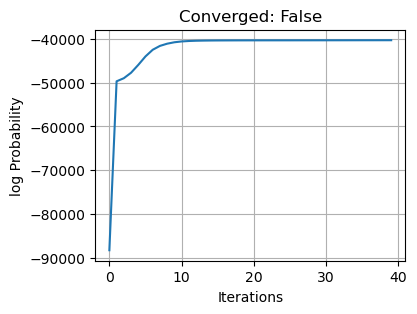

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(model._history)
ax.set_title(f"Converged: {len(model._history) < n_iter}")
ax.set_xlabel("Iterations")
ax.set_ylabel("log Probability")
ax.grid()

It actually converged. The criteria I use for early stopping in the implementation is much more strict.

We ignore the validation and test set for this model (and only this model) to keep the implementation simple.

In [18]:
x_sample, state_sequence = model.sample(50)

Let's plot the generated sequence:

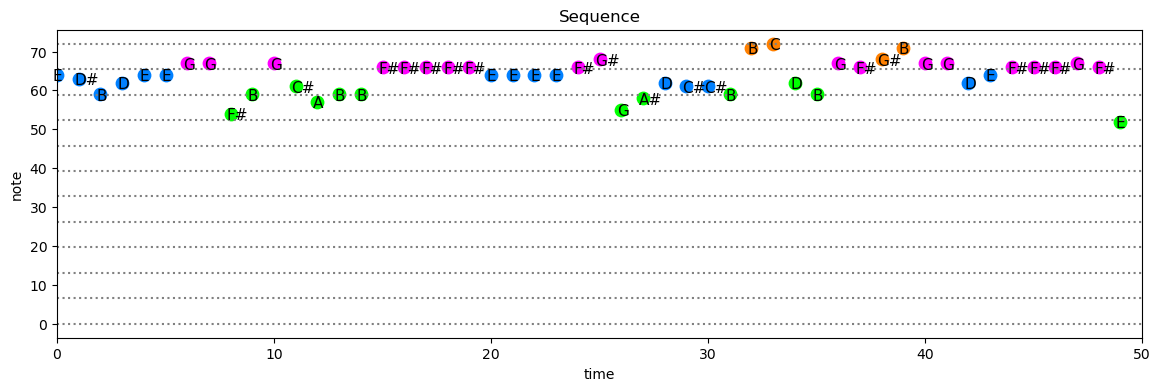

In [19]:
plot_sequence(idx_to_onehot(x_sample), state_sequence)

Almost all the notes in the generated melody are in the E-major scale.

What does it sound like?

In [20]:
write_mp3([[note] for note in x_sample], "out/hmm0_example.mp3")

audio_widget("out/hmm0_example.mp3")

## Multiple notes

Let's now implement a few HMMs using pyro.

In [21]:
def train(model, seqs_train, seqs_val, seqs_test, hidden_dim, batch_size, num_steps, lr=0.1, step_every=10):
    # prepare data
    sequences_train = torch.from_numpy(idx_to_onehot_multi(seqs_train)).float()
    lengths_train = torch.tensor([len(song) for song in seqs_train])

    sequences_val = torch.from_numpy(idx_to_onehot_multi(seqs_val)).float()
    lengths_val = torch.tensor([len(song) for song in seqs_val])

    sequences_test = torch.from_numpy(idx_to_onehot_multi(seqs_test)).float()
    lengths_test = torch.tensor([len(song) for song in seqs_test])

    # setup optimizer and inference algorithm
    pyro.clear_param_store()

    guide = AutoDelta(poutine.block(model, expose_fn=lambda msg: msg["name"].startswith("probs")))
    optim = ClippedAdam({"lr": lr})
    elbo = TraceEnum_ELBO(max_plate_nesting=2)
    svi = SVI(model, guide, optim, elbo)

    data_dim = sequences_train.shape[-1]

    train_losses = []
    val_losses = []

    for step in range(num_steps):

        # take a gradient step
        svi.step(sequences_train, lengths_train, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)

        # compute loss
        with torch.no_grad():
            loss_train = elbo.loss(model, guide, sequences_train, lengths_train, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
            loss_train /= sequences_train.shape[0]

            loss_val = elbo.loss(model, guide, sequences_val, lengths_val, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
            loss_val /= sequences_val.shape[0]

            train_losses.append(loss_train)
            val_losses.append(loss_val)
            
        if step_every != -1 and step % step_every == 0:
            print(f"Step {step} - Train loss: {loss_train:.2f} - Validation loss: {loss_val:.2f}")

    test_loss = elbo.loss(model, guide, sequences_test, lengths_test, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
    test_loss /= sequences_test.shape[0]

    return {
        "model": model,
        "guide": guide,
        "data_dim": data_dim,

        "train_losses": train_losses,
        "val_losses": val_losses,
        "test_loss": test_loss,
    }

In [22]:
def sample(model, guide, n_samples, **model_kwargs):
    trained_model = poutine.condition(model, guide() if guide is not None else {})
    posterior_samples, posterior_hidden = trained_model(None, torch.tensor([n_samples]), **model_kwargs)

    posterior_samples = posterior_samples.numpy()
    posterior_hidden = posterior_hidden.numpy()

    return posterior_samples, posterior_hidden

### Data preprocessing

We will now use use up to 4 notes per time step (all notes available in the dataset).

In [23]:
seqs_train = seqs_train_
seqs_val   = seqs_val_
seqs_test  = seqs_test_

### HMM-1

This model HMM-1 is similiar to the model HMM-0. However, it is *now* possible for the model to guess that multiple notes are playing at the same time step. To do this, we assume that at each timestep there are K observed values (instead of a single value) from K random variables. 

In the generative process the transition probability distribution follows a categorical (Multinomial) distribution, and the emission probability distribution follows a Bernoulli distribution for each $y_k$:
$$
x_t \sim \text{Cat}(x_t \mid \text{t}_{x_{t-1}}) \\
y_{t,k} \sim \text{Ber}(y_{t,k} \mid \text{e}^k_{x_{t}})
$$

Note $\mathbf{y}_t$ is a 88-dimensional vector (each of the midi keys). Hence, multiple notes may occur within the same timestep since there are  88 "independent" [note not played := 0, note played := 1] states.

In [24]:
def model_1(sequences, lengths, data_dim, hidden_dim, batch_size=None, include_prior=True):
    if sequences is not None:
        num_sequences, max_length, _ = map(int, sequences.shape)
    else:
        # when sampling, sample a single sequence
        num_sequences = 1
        max_length = lengths.max()

    assert lengths.shape == (num_sequences,)
    assert lengths.max() <= max_length
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample(
            "probs_x",
            dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1),
        )
        probs_y = pyro.sample(
            "probs_y",
            dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2),
        )
    
    tones_plate = pyro.plate("tones", data_dim, dim=-1)
    
    x_seq = torch.zeros(max_length, dtype=torch.long)
    y_seq = torch.zeros(max_length, data_dim)

    # vectorize the batches
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lens = lengths[batch]
        x = 0 # initial hidden state
        for t in pyro.markov(range(lens.max())):
            with poutine.mask(mask=(t < lens).unsqueeze(-1)):
                x = pyro.sample(
                    "x_{}".format(t),
                    dist.Categorical(probs_x[x]),
                    infer={"enumerate": "parallel"},
                )
                x_seq[t] = x[0]

                with tones_plate:
                    y_seq[t] = pyro.sample(
                        "y_{}".format(t),
                        dist.Bernoulli(probs_y[x.squeeze(-1)]),
                        obs=sequences[batch, t] if sequences is not None else None,
                    )[0]

    return y_seq, x_seq

Let's define the parameters of the model.

In [25]:
model = model_1
hidden_dim = 6

... and the training parameters:

In [26]:
train_result = train(model, seqs_train, seqs_val, seqs_test, hidden_dim=hidden_dim, batch_size=12, num_steps=200, lr=0.1)

Step 0 - Train loss: 1549.59 - Validation loss: 1247.47
Step 10 - Train loss: 1080.89 - Validation loss: 1129.09
Step 20 - Train loss: 1033.17 - Validation loss: 913.09
Step 30 - Train loss: 765.44 - Validation loss: 902.75
Step 40 - Train loss: 801.69 - Validation loss: 723.01
Step 50 - Train loss: 705.75 - Validation loss: 553.47
Step 60 - Train loss: 610.79 - Validation loss: 513.47
Step 70 - Train loss: 607.90 - Validation loss: 750.39
Step 80 - Train loss: 613.85 - Validation loss: 543.96
Step 90 - Train loss: 507.86 - Validation loss: 564.12
Step 100 - Train loss: 680.10 - Validation loss: 584.56
Step 110 - Train loss: 662.05 - Validation loss: 558.64
Step 120 - Train loss: 550.10 - Validation loss: 602.84
Step 130 - Train loss: 514.81 - Validation loss: 404.94
Step 140 - Train loss: 489.08 - Validation loss: 418.86
Step 150 - Train loss: 609.10 - Validation loss: 476.49
Step 160 - Train loss: 612.59 - Validation loss: 521.76
Step 170 - Train loss: 465.58 - Validation loss: 435.2

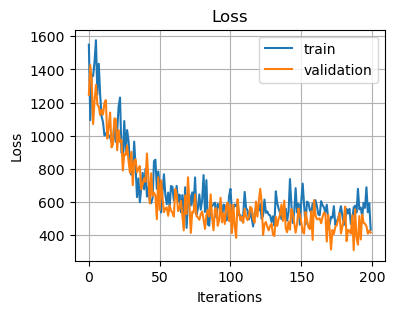

In [27]:
plot_loss(train_result["train_losses"], train_result["val_losses"])

In [28]:
print(f"Test loss: {train_result['test_loss']:.2f}")

Test loss: 480.72


Let's sample a sequence from the model and plot it.

In [29]:
model, guide, data_dim = train_result["model"], train_result["guide"], train_result["data_dim"]

posterior_samples, posterior_hidden = sample(model, guide, n_samples=100, data_dim=data_dim, hidden_dim=hidden_dim)

Let's take a look at the transition matrix and the distribution of the hidden states for the previously sampled data.

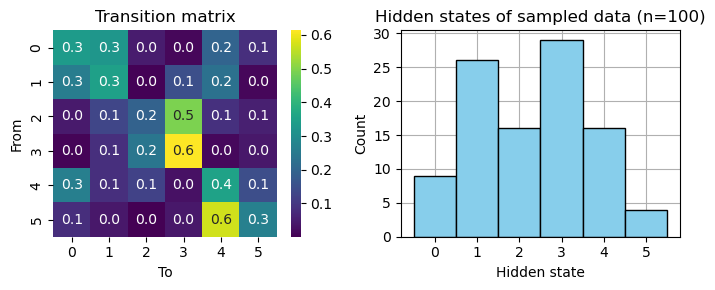

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
heatmap_transition_matrix(guide()["probs_x"].detach().numpy(), ax=axes[0])
plot_hidden_states_histogram(posterior_hidden, hidden_dim=hidden_dim, ax=axes[1])
fig.tight_layout()

Let's plot the sequence generated by the model:

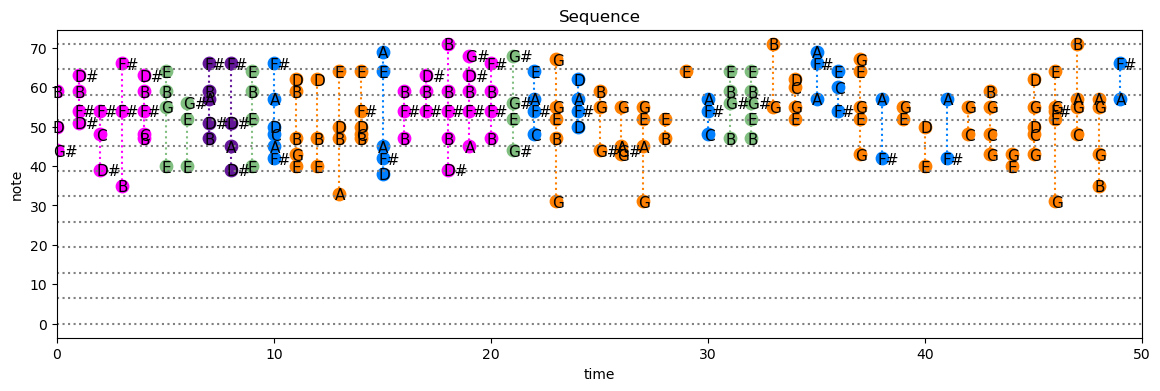

In [31]:
n = 50
plot_sequence(posterior_samples[:n], posterior_hidden[:n])

In [32]:
print(f"Average number of notes per timestep: {np.sum(posterior_samples) / len(posterior_samples)}")

Average number of notes per timestep: 3.74


The average number of midi notes per timestep is consistent with the data, which has on avg. 3.89 notes per timestep (see figure above in Data exploration).

Let's listen to the sample previously generated by the model:

In [33]:
x_samples = posterior_samples.astype(int)
x_example = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm1_example.mp3")
audio_widget("out/hmm1_example.mp3")

Let's also just hear what the untrained HMM-1 model sounds like. <span style="color:red">Warning: jump scare! </span>

In [34]:
posterior_samples, posterior_hidden = sample(model, guide=None, n_samples=50, data_dim=data_dim, hidden_dim=hidden_dim)

x_samples = posterior_samples.astype(int)
x_examplmidie = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm1_example_no_training.mp3", volume=70) # turn volume down from 100 to 70.
audio_widget("out/hmm1_example_no_training.mp3")

### HMM-2

This model HMM-2 is similiar to the model HMM-1. However, assumes the previosly observed value influences the next observed value as well.

In the generative process the transition probability distribution follows a categorical (Multinomial) distribution, and the emission probability distribution follows a Bernoulli distribution for each $y_k$:
$$
x_t \sim \text{Cat}(x_t \mid \text{t}_{x_{t-1}}) \\
y_{t,k} \sim \text{Ber}(y_{t,k} \mid \text{e}^k_{x_{t}, y_{t-1}})
$$

Note $\mathbf{y}_t$ is a 88-dimensional vector (each of the midi keys). Hence, multiple notes may occur within the same timestep since there are  88 "independent" [note not played := 0, note played := 1] states.

In [43]:
def model_2(sequences, lengths, data_dim, hidden_dim, batch_size=None, include_prior=True):
    if sequences is not None:
        num_sequences, max_length, _ = map(int, sequences.shape)
    else:
        # when sampling, sample a single sequence
        num_sequences = 1
        max_length = lengths.max()

    assert lengths.shape == (num_sequences,)
    assert lengths.max() <= max_length
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample(
            "probs_x",
            dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1),
        )
        probs_y = pyro.sample(
            "probs_y",
            dist.Beta(0.1, 0.9).expand([hidden_dim, 2, data_dim]).to_event(3),
        )
    
    tones_plate = pyro.plate("tones", data_dim, dim=-1)
    
    x_seq = torch.zeros(max_length, dtype=torch.long)
    y_seq = torch.zeros(max_length, data_dim)

    # vectorize the batches
    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lens = lengths[batch]
        x = 0 # initial state
        y = 0 # "imaginary" state before initial state
        for t in pyro.markov(range(lens.max())):
            with poutine.mask(mask=(t < lens).unsqueeze(-1)):
                x = pyro.sample(
                    "x_{}".format(t),
                    dist.Categorical(probs_x[x]),
                    infer={"enumerate": "parallel"},
                )
                x_seq[t] = x[0]

                with tones_plate as tones:
                    y = pyro.sample(
                        "y_{}".format(t),
                        dist.Bernoulli(probs_y[x, y, tones]),
                        obs=sequences[batch, t] if sequences is not None else None,
                    ).long()
                    y_seq[t] = y[0]

    return y_seq, x_seq

Let's define the parameters of the model.

In [44]:
model = model_2
hidden_dim = 6

... and the training parameters:

In [45]:
train_result = train(model, seqs_train, seqs_val, seqs_test, hidden_dim=hidden_dim, batch_size=12, num_steps=200, lr=0.1)

Step 0 - Train loss: 1371.81 - Validation loss: 1243.39
Step 10 - Train loss: 1030.73 - Validation loss: 1149.53
Step 20 - Train loss: 899.16 - Validation loss: 870.30
Step 30 - Train loss: 815.48 - Validation loss: 719.22
Step 40 - Train loss: 610.12 - Validation loss: 581.96
Step 50 - Train loss: 714.87 - Validation loss: 470.86
Step 60 - Train loss: 616.34 - Validation loss: 589.15
Step 70 - Train loss: 626.84 - Validation loss: 442.40
Step 80 - Train loss: 428.48 - Validation loss: 433.13
Step 90 - Train loss: 560.77 - Validation loss: 427.77
Step 100 - Train loss: 525.24 - Validation loss: 396.90
Step 110 - Train loss: 491.99 - Validation loss: 305.08
Step 120 - Train loss: 527.66 - Validation loss: 294.22
Step 130 - Train loss: 502.82 - Validation loss: 399.74
Step 140 - Train loss: 524.69 - Validation loss: 273.40
Step 150 - Train loss: 429.32 - Validation loss: 194.09
Step 160 - Train loss: 400.05 - Validation loss: 316.53
Step 170 - Train loss: 470.48 - Validation loss: 188.61

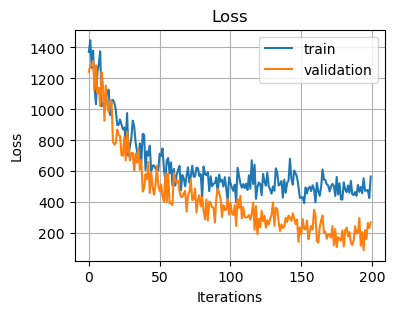

In [47]:
plot_loss(train_result["train_losses"], train_result["val_losses"])

In [48]:
print(f"Test loss: {train_result['test_loss']:.2f}")

Test loss: 313.98


Let's sample a sequence from the model and plot it.

In [49]:
model, guide, data_dim = train_result["model"], train_result["guide"], train_result["data_dim"]

posterior_samples, posterior_hidden = sample(model, guide, n_samples=100, data_dim=data_dim, hidden_dim=hidden_dim)

Let's take a look at the transition matrix and the distribution of the hidden states for the previously sampled data.

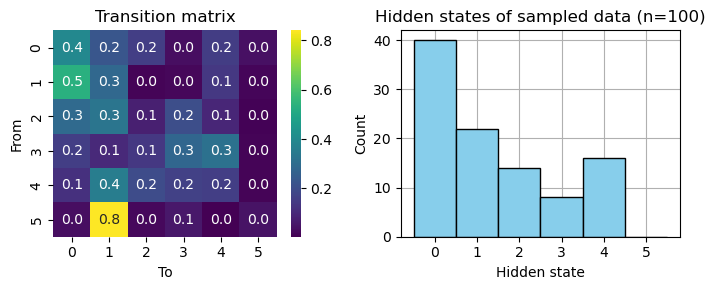

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(7, 3))
heatmap_transition_matrix(guide()["probs_x"].detach().numpy(), ax=axes[0])
plot_hidden_states_histogram(posterior_hidden, hidden_dim=hidden_dim, ax=axes[1])
fig.tight_layout()

Let's plot the sequence generated by the model:

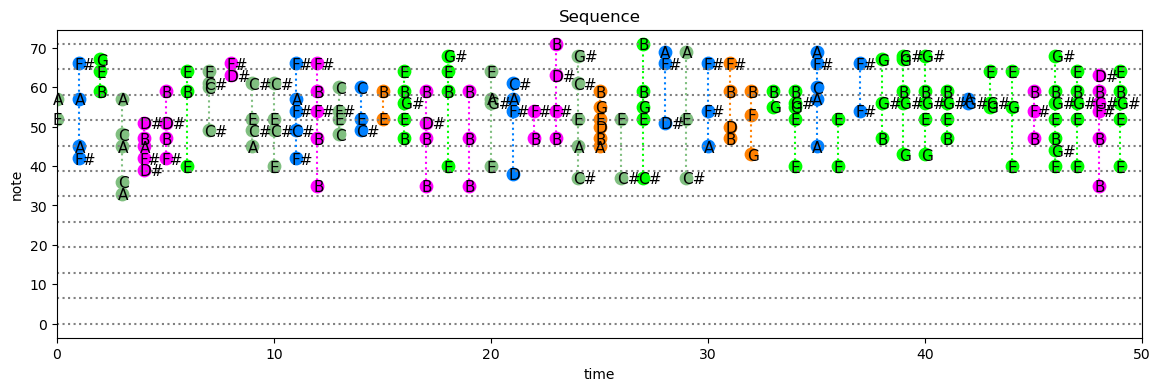

In [51]:
n = 50
plot_sequence(posterior_samples[:n], posterior_hidden[:n])

In [52]:
print(f"Average number of notes per timestep: {np.sum(posterior_samples) / len(posterior_samples)}")

Average number of notes per timestep: 4.07


The average number of midi notes per timestep is consistent with the data, which has on avg. 3.89 notes per timestep (see figure above in Data exploration).

Let's listen to the sample previously generated by the model:

In [53]:
x_samples = posterior_samples.astype(int)
x_example = [one_hot_to_idx(sequence) for sequence in x_samples]

write_mp3(x_example, "out/hmm2_example.mp3")
audio_widget("out/hmm2_example.mp3")

## Conclusion

In this project, we first implemented a HMM from scratch, which assumed a single note per timestep. We then implemented more complex models that allowed for multiple notes per timestep - using pyro. We trained the models on a dataset of Bach chorales and generated new sequences of notes. The models were able to generate sequences that sounded like music.

In most music pieces, notes have variable lengths. In the JSB chorales dataset, all notes had the same duration (one quarter note each). A simple solution to handle music pieces with variable length notes would be to set a models "timesteps" to the smallest note duration and cut notes with larger duration into multiple of smaller (and same) durations. To handle larger notes being played ("pressed") longer (multiple "timesteps"), a HMM variant may include an encoding of a note being "pressed" and "released" (instead of only "pressed" as it is currently).